In [50]:
import astropy
from scipy.optimize import minimize, curve_fit
from gaia_tools import query
import emcee
import corner
from galpy.util import bovy_plot
from scipy.interpolate import CubicSpline
from galpy.util import bovy_coords, bovy_plot
import pandas

from misc import ncount,bootstrap
from random import randint

import warnings
warnings.simplefilter("ignore")

import matplotlib.colors as mcolors

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Number Count Asymmetry

Calculates the number count asymmetry in the solar neighbourhood. The code starts by fitting a two component model to the number counts for different absolute magnitude-colour bins to recover the sun's vertical position, zsun. We then use this measurement to adjust the number counts and calculate the vertical asymmetry in the number counts about the Galactic mid-plane. Finally, we use an estimate of the number count asymmetry to refit the number counts to a new model which accounts for the perturbation.

We start by choosing what cuts to make on the colours and magnitudes of our samples. To do this, we download a sample set of stars from the solar neighbourhood. We also nickname the query so that the output is not deleted when the cache is cleared weekly.

In [51]:
bprpMg_query='''SELECT -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag AS mg, bp_rp FROM gaiadr2.gaia_source
WHERE parallax_over_error > 10
AND phot_g_mean_flux_over_error>50
AND phot_rp_mean_flux_over_error>20
AND phot_bp_mean_flux_over_error>20
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
AND parallax > 4'''

out= query.query(bprpMg_query,local=False)
query.cache.nickname(bprpMg_query,'cmd_query')

True

We then use the number counts as a function of magnitude for different colour bins to fit a Gaussian distribution to the main sequence peak. These determin the different colour-magnitude bins used throughout the analysis.

In [52]:
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
  
def findbin(mag,around):
    y,x= histogram(mag,bins=101)
    x= [(x[i]+x[i+1])/2. for i in range(101)]
    popt,pcov = curve_fit(gaus,x[argmax(y)-around[0]:argmax(y)+around[1]],y[argmax(y)-around[0]:argmax(y)+around[1]],p0=[350000.,x[argmax(y)],1.])

    xmodel= linspace(-3,15,10000)
    mean= popt[1]
    var= abs(popt[2])
    
    return [round(mean-2.*var,2),round(mean+2.*var,2)]

mg_cmd= out['mg']; bprp_cmd= out['bp_rp']
bprp_edges= arange(0.7,2.1+0.1,0.1)
Mg_edges= zeros((len(bprp_edges)-1,2))

for i in range(len(bprp_edges)-1):
    a= [5,7] if (i<13) else [17,17]
    if (i>16):
        a=[31,31]
    
    Mg_edges[i]= findbin(mg_cmd[(bprp_cmd>bprp_edges[i])*(bprp_cmd<bprp_edges[i+1])],around=a)

Next, use this bins to query the Gaia arxiv for the positions of all the stars. Again, the query nickname means that we only have to actually query the archive once, and after that it is saved in our cache.

In [5]:
queries= []
for i in range(len(Mg_edges)):
    queries.append("""SELECT cos(RADIANS(b))*(1/parallax)*cos(RADIANS(l)) AS x, 
cos(RADIANS(b))*(1/parallax)*sin(RADIANS(l)) AS y, 
(1/parallax)*sin(RADIANS(b)) AS z
FROM gaiadr2.gaia_source
WHERE phot_g_mean_mag BETWEEN 7 AND 17
AND (1/parallax)*cos(RADIANS(b)) < 0.25 
AND parallax_over_error > 5
AND bp_rp BETWEEN {0:.2f} AND {1:.2f}
AND -5*LOG(1000/parallax)/LOG(10)+5+phot_g_mean_mag BETWEEN {2:.1f} AND {3:.1f}"""\
          .format(bprp_edges[i],
                  bprp_edges[i+1],
                  Mg_edges[i,0],
                  Mg_edges[i,1]))

out= [None] * len(queries) # Output from the queries
bprp= [None] * len(queries) # X,Y,Z positions for the different colour bins

for i in range(len(queries)):
    out[i]= query.query(queries[i],local=False)
    bprp[i]= array([out[i]['x'],out[i]['y'],out[i]['z']])
for i,q in enumerate(queries):
    nick= 'ncount'+str(round(bprp_edges[i],1))
    query.cache.nickname(q,nick)

Next, we create the number count objects for each colour bin defined by the ncount class defined in misc.

Properties of each object:
- self.x,self.y,self.z: rectangular Galactic coordinates
- self.Mg: Absolute magnitude range
- self.binw: width of each bin in z
- self.g: initial guess for the number count 2-component model fit
- self.br: Range of $G_{BP}-G_{RP}$ of the sample
- self.mcmc: Boolean indicating whether or not the object should run an mcmc analysis
- self.lim: Range of distances over which the cylinder is complete
- self.area: The area of each bin in z
- self.r: Same as self.lim, but rounded to two decimal places
- self.b: Bin edges for the splitting along z
- self.zbin_uncut, self.N_uncut: Bin midpoints and number counts before cutting on complete distances
- self.zbin, self.N: Bin midpoints and number counts after cutting on the distances over which the cylinder is complete
- self.zmodel: Evenly spaced bins in z at which the model is calculated
- self.n0,self.zsun,self.H1,self.f,self.H2: Best fit parameters to the two-component model
- Only if mcmc = True:
    - self.sample: Samples from an MCMC analysis
    - self.n0_mcmc, self.z0_mcmc, self.h1_mcmc, self.f_mcmc, self.h2_mcmc: Best fit parameters for the two-component fit. Each is a 3-element array where 0-best value, 1-negative uncertainty, and 2-positive uncertainty
- self.zA,self.A,self.A_err: Asymmetry bins in z, asymmetry amplitude, error in the asymmetry

Functions included in the class:
- calc_lim(): Calculate the heights over which the cylinder is complete
- print_lim(): Print the height range in a cohesive way
- calc_count(): Calculate the number count at different zbins between the heights specified by calc_lim()
- n_model(params,zdata): Calculate the two-component model for a set of parameters
- nloglikelihood(params,data): Calculate the log likelihood for the above model and a set of data
- calc_sechfit(): Calculates the best fit parameters to the n_model
- calc_mcmc(): Runs a Markov Chain Monte Carlo analysis on the the number count using the n_model
- calc_A(z0='nan'): Calculates the asymmetry in the number counts after shifting by z0. If not specified, z0=self.z0 or self.z0_mcmc
- plot_xyz2D(): Plots the stars on on x vs. z grid 
- plot_sechfit(): Plots the best fit model. Uses the MCMC parameters if self.mcmc=True
- plot_A(style='points'): Plots the asymmetry using the colour scale used in the paper 
- Only if mcmc = True:
    - calc_psech_mcmc(): Calculates the best fit parameters to the n_model using mcmc
    - plot_corner(): Corner plot of the samples from the mcmc
    - print_mcmc_bestfit(): Prints the best fit parameters from the mcmc

In [6]:
br_all= [None] * len(queries) # ncount objects defined in misc.py  

mag_data= [b.T for b in bprp]
binw_all= [0.025,0.025,0.025,0.025,0.025,0.025,0.02,0.02,0.02,0.015,0.015,
           0.015,0.01,0.01,0.01]
guess_all= [[0.8,0.03,0.1,0.1,0.5],[0.8,0.03,0.1,0.1,0.5],[0.8,0.03,0.2,0.1,0.5],
            [0.8,0.03,0.2,0.1,0.4],[0.8,0.03,0.2,0.15,0.4],[0.8,0.03,0.2,0.15,0.4],[0.7,0.03,0.2,0.15,0.4],
            [0.7,0.03,0.2,0.15,0.4],[0.6,0.03,0.2,0.15,0.4],[0.7,0.03,0.2,0.15,0.3],[0.7,0.03,0.2,0.25,0.4],
            [0.7,0.03,0.2,0.25,0.4],[0.7,0.03,0.2,0.25,0.4],[0.7,0.03,0.2,0.25,0.4],[0.8,0.03,0.1,0.1,0.4]]

for i in range(len(mag_data)):
    br_all[i]= ncount(mag_data[i],Mg_edges[i],bprp_edges[i],binw_all[i],guess_all[i],mcmc=True)

Now we generate Figure 1 in the paper by over plotting our colour-magnitude bins on an HR diagram of the initial sample in a 250 pc sphere. We also have a subplot of the number of star in each bin. 

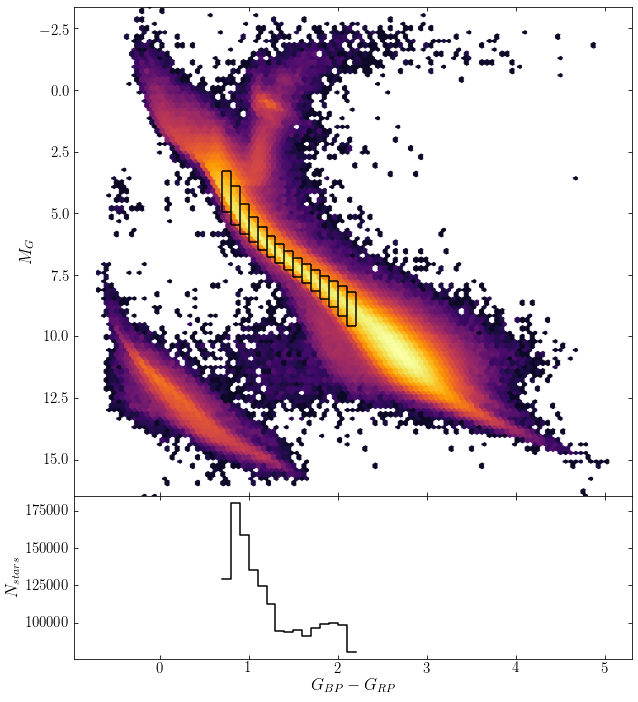

In [9]:
nstars= append(sum(br_all[0].N),[sum(b.N) for b in br_all])

mgplot= zeros((len(bprp_edges)+1,2))
mgplot[1:-1]= Mg_edges; mgplot[0]=Mg_edges[0]; mgplot[-1]=Mg_edges[-1]

colors = np.vstack(([1.,1.,1.,1.], plt.cm.inferno(np.linspace(0, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,12)

fig, (ax1,ax2)= subplots(2,sharex=True,gridspec_kw = {'height_ratios':[3, 1]})
fig.subplots_adjust(hspace=0)
ax1.hexbin(bprp_cmd,mg_cmd,bins='log',cmap=cmap,gridsize=100)
ax1.invert_yaxis()

for i in range(len(bprp_edges)):
    ax1.vlines(bprp_edges[i],mgplot[i][0],mgplot[i+1][1],color='k')
    if i<len(bprp_edges)-1:
        ax1.hlines(mgplot[i+1][0],bprp_edges[i],bprp_edges[i+1],color='k') 
        ax1.hlines(mgplot[i+1][1],bprp_edges[i],bprp_edges[i+1],color='k')
        
ax1.tick_params(axis='both')
ax1.set_ylabel(r'$M_G$')
ax2.set_xlabel(r'$G_{BP}-G_{RP}$')
ax2.tick_params(axis='both')
ax2.set_ylabel(r'$N_{stars}$')

ax2.step(bprp_edges,nstars,'k')

Using the bootstrapping function as well as the calculated $z_\odot$ for each colour bin, we calculate the median value and it's error. 

In [72]:
z0= array([b.z0_mcmc[0] for b in br_all])
avez0, sig= bootstrap(z0,100000)
 
print('The average value for zsun is: ', round(avez0*1000,1),' +/- ',round(sig*1000,1), ' pc.')

The average value for zsun is:  20.3  +/-  0.7  pc.


Next, we plot figure 3 from the paper by plotting the number counts for each colour bin. We have to scale them alll to the same amplitude and then shift them to make sure the trends are clearly visible. The subplot indicates the residuals of the two-component model best fit. 

[]

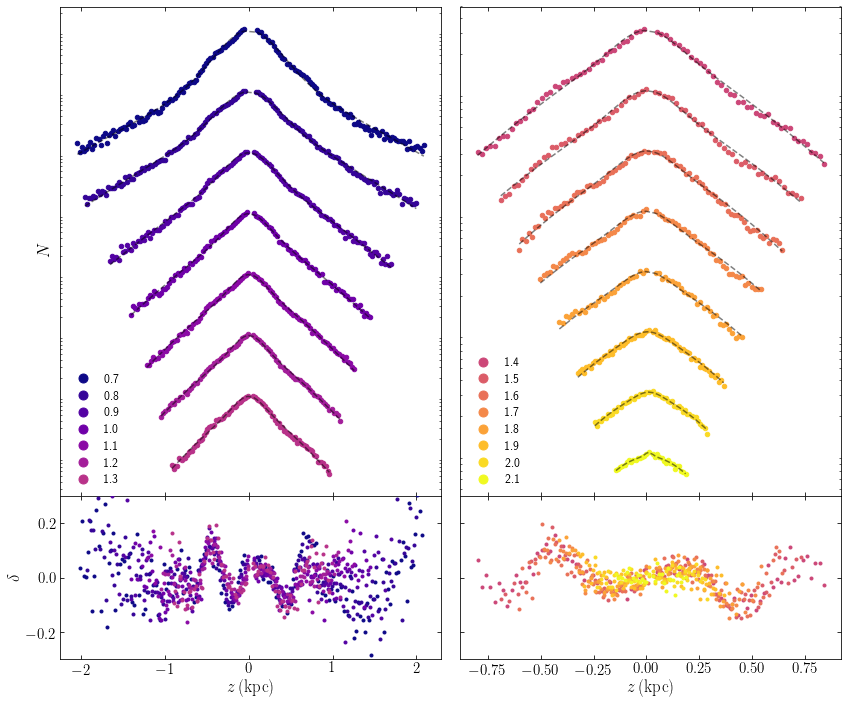

In [12]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(14,12)

fig, (ax,res) = plt.subplots(nrows=2, ncols=2, gridspec_kw = {'height_ratios':[3, 1]})
fig.subplots_adjust(hspace=0,wspace=0.05)

ax[0].set_ylabel(r'$N$')
res[0].set_ylabel(r'$\delta$')


#MCMC BEST FIT
for i,b in enumerate(br_all[::-1]):
    
    mbin= b.zbin+avez0
    Model= b.n_model(b.psech,b.zbin)
    
    N= b.N/max(Model)
    N_err= sqrt(b.N)/max(Model)
    Model= Model/max(Model)
    
    k=1 if (i<(len(br_all))/2) else 0
    
    ax[k].semilogy(mbin,Model*10**(i*(1-k/2)),'k--',alpha=0.5,zorder=30-i)  
    ax[k].semilogy(mbin,N*10**(i*(1-k/2)),'.',
                   color=plt.cm.plasma(1./(bprp_edges[-2]-bprp_edges[0])*(bprp_edges[-(i+2)]-0.7)),
                   label=str(round(bprp_edges[-(i+2)],1)),ms=9)
    
    handles, labels = ax[k].get_legend_handles_labels()
    ax[k].legend(handles[::-1], labels[::-1],markerscale=2,loc=3,frameon=False) 
    ax[k].set_yticks([])
   

    res[k].plot(mbin,(N-Model)/Model,'.',color=plt.cm.plasma(1./(bprp_edges[-2]-bprp_edges[0])*(bprp_edges[-(i+2)]-0.7)),
                label=str(round(bprp_edges[i],1)),zorder=20-i) 
    res[k].set_ylim([-0.3,0.3])
    res[k].set_xlabel(r'$z\,(\mathrm{kpc})$')
    res[k].tick_params(axis='both')

res[1].set_yticklabels([])


#savefig('ncounts.pdf',bbox_inches='tight')

We then calculate the asymmetry using the median value of zsun calculated above to shift the number counts. To find the error in each bin, we use a bootstraping technique. We also plot the median uncertainty in each bin along with the spread as a comparison. 

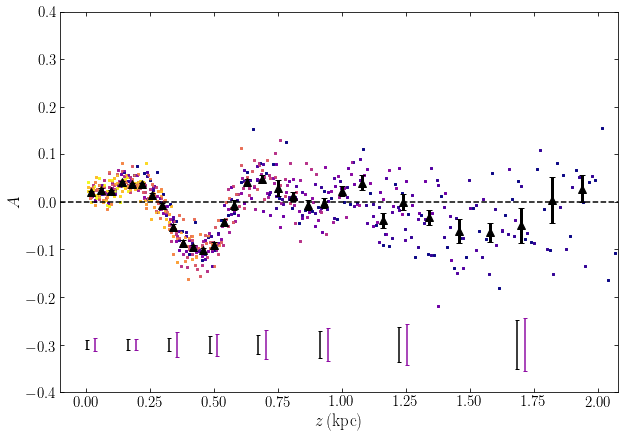

In [73]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,7)

zA_bins= append(append(append(arange(0.,0.64,0.04),arange(0.66,0.97,0.06)),arange(1.04,1.3,0.08)),arange(1.4,2.1,0.12))

y= empty(len(zA_bins)-1)
y_err= empty(len(zA_bins)-1)
sig= empty(len(y))
A_b= empty(len(zA_bins)-1)
Aerr_b= empty(len(y))
N_len= empty(len(y))

for i in range(len(y)):
    tot=[]
    tot_err=[]
    for j,b in enumerate(br_all):
        zA, A, A_err= b.calc_A(z0=avez0)
        tot= append(tot,A[(zA>zA_bins[i])*(zA<zA_bins[i+1])])
        tot_err= append(tot_err,A_err[(zA>zA_bins[i])*(zA<zA_bins[i+1])])
        
        plot(zA,A,'.',color=plt.cm.plasma(1./(bprp_edges[-2]-bprp_edges[0])*(bprp_edges[j]-0.7)),ms=2)

    y[i]= median(tot)
    y_err[i]= median(tot_err)
    sig[i]= std(tot)
    A_b[i], Aerr_b[i]= bootstrap(tot,10000)
    N_len[i]= len(tot)
    
mid = [(zA_bins[i]+zA_bins[i+1])/2. for i in range(len(y))]

i_err= 4
errorbar(mid,A_b,yerr=Aerr_b,color='k',fmt='^',ms=8,capsize=3.,lw=3,zorder=100)
errorbar(array(mid[::i_err])-0.015,A_b[::i_err]*0.-0.3,yerr=y_err[::i_err],fmt='.',ms=0,capsize=2.,color='k')
errorbar(array(mid[::i_err])+0.015,A_b[::i_err]*0.-0.3,yerr=sig[::i_err],fmt='.',ms=0,capsize=2.,color=plt.cm.plasma(0.3))
axhline(0.,ls= '--',color='k')
ylabel(r'$A$')
xlabel(r'$z\,(\mathrm{kpc})$')
ylim([-0.4,0.4])
xlim([-0.1,2.08])

savefig('asymmetry.pdf',bbox_inches='tight')

Define functions which calulate the loglikelihood, the two-component model of the disk if we include the asymmetry parameter, and the MCMC. Within the model, we also fit a cubic spline to the asymmetry of the vertical number counts. 

In [74]:
def likeli(params,data,Asym_l):
    z= data[1]
    N= data[0]
    
    if (params[4]>5. or params[4]<0):
        return inf
    if (params[3]>10. or params[3]<0.):
        return inf
    if (params[2]<0. or params[2]>5.):
        return inf
    if (params[1]<-0.1 or params[1]>0.1):
        return inf
    
    model= nasym_model(params,z,Asym_l)

    loglike= -model+N*log(model)
    return -sum(loglike)
        
def nasym_model(params,zdata,Asym_m):
    ln_n0,zsun,H1,f,H2 = params
    n0= 10.**(ln_n0)
    Nobs= n0*(1./cosh((zdata+zsun)/(2.*H1))**2+f*1./cosh((zdata+zsun)/(2.*H2))**2)
    zobs= zdata+zsun
    A_func= CubicSpline(mid, Asym_m)
 
    Aobs_p= A_func(zobs[zobs>0])
    Aobs_n= A_func(-zobs[zobs<0])

    n= zeros(len(zdata))

    n[(zobs<0)]= Nobs[(zobs<0)]*(1-Aobs_n)
    n[(zdata+zsun>0)]= Nobs[(zobs>0)]*(1+Aobs_p)

    return n

def calc_mcmc(data,guess,Asym_mcmc,nsteps):
        ndim= len(zsun_guess[0])
        nwalkers= round(nsteps*0.1)
        
        mask= [(data[1]>-2.08)*(data[1]<2.08)]
        fit= minimize(lambda x: likeli(x,[data[0],data[1]],Asym_mcmc),guess)
        pos= [fit.x+1e-3*np.random.randn(ndim) for i in range(nwalkers)]
        
        sampler= emcee.EnsembleSampler(nwalkers,ndim,lambda x:-likeli(x,[data[0][mask],data[1][mask]],Asym_mcmc))
        sampler.run_mcmc(pos,nsteps)

        samples= sampler.chain[:,(round(nsteps*0.1)):,:].reshape((-1,ndim))
        samples[:,0]= 10.**samples[:,0]
        
        return samples

We now use the above functions to calculate the best fit parameters using the two-component model. We also calculate the uncertainty in each measurement.

In [ ]:
zsun_guess= [[3.5,0.03,0.1,0.1,0.5],[3.5,0.03,0.1,0.1,0.5],[3.5,0.03,0.2,0.1,0.5],
            [3.5,0.03,0.2,0.1,0.4],[3.5,0.03,0.2,0.15,0.4],[3.5,0.03,0.2,0.15,0.4],[3.5,0.03,0.2,0.15,0.4],
            [3.5,0.03,0.2,0.15,0.4],[3.,0.03,0.2,0.15,0.4],[3.5,0.03,0.2,0.15,0.3],[3.5,0.03,0.2,0.25,0.4],
            [3.5,0.03,0.2,0.25,0.4],[3.,0.03,0.2,0.25,0.4],[3.5,0.03,0.2,0.25,0.4],[3.5,0.03,0.1,0.1,0.4]]
z0=zeros([len(br_all),3])
samples= empty([len(br_all),90000,5])

for i,b in enumerate(br_all):
    samples[i]= calc_mcmc([b.N,b.zbin],zsun_guess[i],A_b,1000)
    
zsun_mcmc=[]
zsun_n=[]
zsun_p=[]
for s in samples:
    n0,z0,h1,f,h2= map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                                zip(*np.percentile(s, [16, 50, 84],
                                                                   axis=0)))
    zsun_mcmc= append(zsun_mcmc,z0[0])
    zsun_n= append(zsun_n,z0[1])
    zsun_p= append(zsun_p,z0[2])

We use the solar height above the mid-plane for each colour bin calculated above to plot Figure 5 in the paper. We also include the original $z_\odot$ values from the fit which did not include the asymmetry in the number count density.

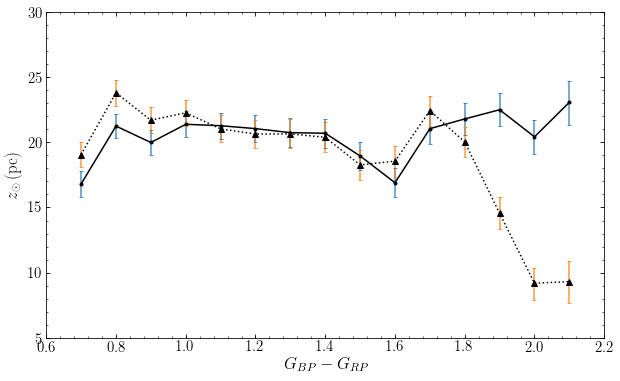

In [80]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,6)

bovy_plot.bovy_plot(bprp_edges[:-1],zsun_mcmc*1000.,
                    'k.-',
                    xrange=[0.6,2.2],
                    yrange=[5,30],
                   xlabel=r'$G_{BP}-G_{RP}$',
                   ylabel=r'$z_\odot\,(\mathrm{pc})$')  

errorbar(bprp_edges[:-1],zsun_mcmc*1000.,yerr=[zsun_n*1000.,zsun_p*1000.],marker='None',ls='None',alpha=0.8,capsize=2.)
br= [b.br for b in br_all]
old_zsun= array([b.z0_mcmc[0] for b in br_all])
zsun_err= array([[b.z0_mcmc[1],b.z0_mcmc[2]] for b in br_all])
plot(br,old_zsun*1000.,'k:',marker='^')
errorbar(br,old_zsun*1000.,yerr=zsun_err.T*1000.,marker='None',ls='None',alpha=0.8,capsize=2.)

savefig('zsun.pdf',bbox_inches='tight')

Now compare the new value for $z_\odot$ to the new one as well as the uncertainty:

In [83]:
vave_old, vsig_old= np.round(array(bootstrap(old_zsun,10000)),4)
vave_new, vsig_new= np.round(array(bootstrap(zsun_mcmc,10000)),4)

print('The original value for the solar height was:',round(vave_old*1000,1),'+/-',vsig_old*1000,'pc')
print('The new value for the solar height is:',vave_new*1000,'+/-',vsig_new*1000,'pc')

The original value for the solar height was: 20.3 +/- 0.7 pc
The new value for the solar height is: 20.8 +/- 0.3 pc


Finally, we calculate the asymmetry using the new approximation for the solar height above the mid-plane and save to a text file entitled 'Asym_bin.txt'.

In [47]:
A_b= empty(len(zA_bins)-1)
Aerr_b= empty(len(y))

for i in range(len(y)):
    tot=[]
    tot_err=[]
    for j,b in enumerate(br_all):
        zA, A, A_err= b.calc_A(z0=vave_new)
        tot= append(tot,A[(zA>zA_bins[i])*(zA<zA_bins[i+1])])
        tot_err= append(tot_err,A_err[(zA>zA_bins[i])*(zA<zA_bins[i+1])])
        
    A_b[i], Aerr_b[i]= bootstrap(tot,10000)
    
mid = [(zA_bins[i]+zA_bins[i+1])/2. for i in range(len(y))]

np.savetxt('Asym_bin.txt',[mid,A_b,Aerr_b])